<a href="https://colab.research.google.com/github/AnaBeatrizMassuh/-Classifica-o-de-Imagens-de-Documentos/blob/main/alexnet_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Capítulo 11 - Redes Neurais Convolucionais

## 11.2 - Implementando uma AlexNet para Classificação de Imagens de Documentos

A AlexNet é uma arquitetura rede neural convolucional profunda desenvolvida em 2012 para a tradicional competição de classificação e reconhecimento de imagens ImageNet.

Você pode consultar o artigo da AlexNet [aqui](https://papers.nips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf).

A arquitetura da AlexNet é representada graficamente pela seguinte figura:

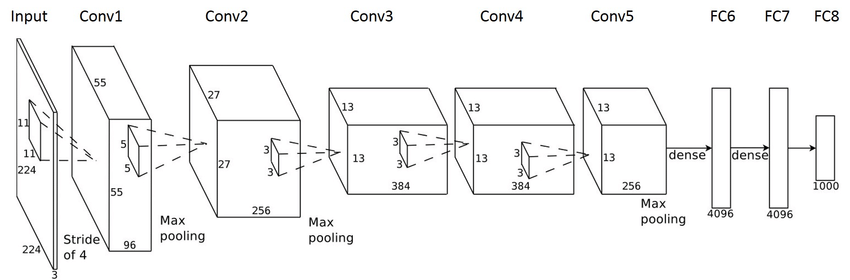

Informações sobre a coleção de imagens utilizada. É uma amostragem aleatória do conjunto

In [ ]:
!pip install -U keras
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 31.8 MB/s 
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.2+zzzcolab20220719082949 requires keras<2.9,>=2.8.0rc0, but you have keras 2.9.0 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 31.7 MB/s 
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0


### Leitura das imagens

Fazer o carregamento de coleções de imagens que estão já carregadas dentro do Keras-tensorflow é tranquilo, vide o [Cifar-10 (recomendo ver este link)](https://keras.io/api/datasets/cifar10/). E quando temos e queremos processar nossas próprias imagens? Aí é um pouco mais difícil, mas não impossível!

Para viabilizar o carregamento das imagens em uma estrutura que permita ler as imagens do disco e processá-las pelos objetos do Keras-tensorflow, vamos utilizar a classe [ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator). Os principais motivos dessa escolha são:

*   Facilidade de se carregar imagens diretamente do disco ou por DataFrames;
*   Facilidade de utilizar operações de pré-processamento (normalização, reescalonamento etc) e que podem ser úteis em uma etapa conhecida como DataAugmentation (veremos adiante)!

### Organizando os arquivos das imagens

A pasta principal da coleção de imagens possui nome "documents". Dentro dessa pasta existem três subpastas, cada uma associada com uma label:

*   documents
    + advertisement
    + email
    + scientific paper

Nesse notebook, teremos que dividir a coleção de imagens em sub-partes (treinamento, validação e testes) utilizando a técnica Holdout. Essa técnica foi escolhida pela sua simplicidade e para facilitar a codificação na sala de aula. Entretanto, recomenda-se o uso da técnica [Stratified K-Fold Cross Validation](lectures/cap08_2_avaliacao_desempenho.ipynb) para avaliação do desempenho da classificação, visto que essa abordagem retorna resultados menos enviesados em relação à amostragem realizada para obter a divisão treinamento-validação-teste e que evita risco de supertreinamento *overfitting*.

Supondo que a pasta "documents" esteja no Google Drive, vamos montar o drive e copiar a pasta para o ambiente no Colab:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!cp -r '/content/drive/MyDrive/documents/' 'documents'

Fazendo-se os imports necessários:

In [3]:
from tensorflow.keras.models import Sequential
from keras.layers import Dense,Activation,Conv2D,MaxPooling2D,BatchNormalization,Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.layers import Dropout
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import os

Leitura de dados

In [4]:
path_documents = 'documents'
lista_subfolders = os.listdir(path_documents)

dataset_dict = {}

dataset_dict['filename'] = []
dataset_dict['label'] = []

for folder in lista_subfolders:
    lista_imagens = os.listdir(path_documents+'/'+folder)

    for img_file in lista_imagens:
        dataset_dict['filename'].append(folder+'/'+img_file)
        dataset_dict['label'].append(folder)

In [7]:
df = pd.DataFrame(dataset_dict,columns=['filename','label'])

In [8]:
X = df['filename'].values
y = df['label'].values

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.6, random_state=42)

Criação dos logits dos labels

In [10]:
from keras.utils.np_utils import to_categorical

train_labels = pd.Categorical(y_train)
valid_labels = pd.Categorical(y_valid)
test_labels = pd.Categorical(y_test)

y_train_int = train_labels.codes
y_valid_int = valid_labels.codes
y_test_int = test_labels.codes

y_train_logits = to_categorical(y_train_int)
y_valid_logits = to_categorical(y_valid_int)
y_test_logits = to_categorical(y_test_int)

In [11]:
lista_train = []
for i in range(0,len(X_train)):
    lista_train.append([X_train[i],y_train[i]])

lista_valid = []
for i in range(0,len(X_valid)):
    lista_valid.append([X_valid[i],y_valid[i]])

lista_test = []
for i in range(0,len(X_test)):
    lista_test.append([X_test[i],y_test[i]])

In [12]:
df_train = pd.DataFrame(lista_train,columns = ['filename','label'])
df_valid = pd.DataFrame(lista_valid,columns = ['filename','label'])
df_test = pd.DataFrame(lista_test,columns = ['filename','label'])

In [13]:
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_dataframe(df_train,
                                              directory=path_documents,
                                              x_col='filename',y_col='label',
                                              class_mode='categorical',
                                              shuffle=True)

valid_generator = datagen.flow_from_dataframe(df_valid,
                                              directory=path_documents,
                                              x_col='filename',y_col='label',
                                              class_mode='categorical',
                                              shuffle=True)

test_generator = datagen.flow_from_dataframe(df_test,
                                              directory=path_documents,
                                              x_col='filename',y_col='label',
                                             class_mode='categorical',
                                              shuffle=True)


Found 2072 validated image filenames belonging to 3 classes.
Found 355 validated image filenames belonging to 3 classes.
Found 534 validated image filenames belonging to 3 classes.


In [14]:
test_generator.image_shape

(256, 256, 3)

Hyperparameters

In [15]:
dims = (224,224,3)
num_classes = 3

In [16]:
model = Sequential()
# Parte 1 da AlexNet
model.add(layers.experimental.preprocessing.Resizing(224,224,interpolation="bilinear",input_shape=(224,224,3)))
model.add(Conv2D(96,(11,11), strides=(4,4)))
model.add(Activation("relu"))
model.add(MaxPooling2D((3, 3),strides=(2,2)))
model.add(BatchNormalization())

# Parte 2 da AlexNet
model.add(Conv2D(256,(5,5), strides=(1,1),padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling2D((3, 3),strides=(2,2)))
model.add(BatchNormalization())

# Parte 3 da AlexNet
model.add(Conv2D(384,(3,3), strides=(1,1),padding="same"))
model.add(Activation("relu"))

model.add(Conv2D(384,(3,3), strides=(1,1),padding="same"))
model.add(Activation("relu"))

model.add(Conv2D(256,(3,3), strides=(1,1),padding="same"))
model.add(Activation("relu"))

model.add(MaxPooling2D((3, 3),strides=(2,2)))

model.add(Flatten())

model.add(Dense(4096))
model.add(Activation("relu"))

model.add(Dropout(0.5))

model.add(Dense(4096))
model.add(Activation("relu"))

model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation("softmax"))

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 54, 54, 96)        34944     
                                                                 
 activation (Activation)     (None, 54, 54, 96)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 26, 26, 96)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 26, 26, 96)       384       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 256)       6

In [18]:
sgd = SGD(lr=0.00001)

model.compile(optimizer=sgd,loss="categorical_crossentropy",metrics=['accuracy'])

model.fit(train_generator,
          epochs=10,
          batch_size=16,
          validation_data=valid_generator)


Epoch 1/10
65/65 [==============================] - 22s 164ms/step - loss: 1.2549 - accuracy: 0.3272 - val_loss: 1.0952 - val_accuracy: 0.3296
Epoch 2/10
65/65 [==============================] - 12s 179ms/step - loss: 1.2063 - accuracy: 0.3576 - val_loss: 1.0960 - val_accuracy: 0.3324
Epoch 3/10
65/65 [==============================] - 11s 164ms/step - loss: 1.1759 - accuracy: 0.3605 - val_loss: 1.0941 - val_accuracy: 0.3324
Epoch 4/10
65/65 [==============================] - 10s 152ms/step - loss: 1.1429 - accuracy: 0.3919 - val_loss: 1.0867 - val_accuracy: 0.3437
Epoch 5/10
65/65 [==============================] - 10s 148ms/step - loss: 1.1121 - accuracy: 0.3919 - val_loss: 1.0699 - val_accuracy: 0.5380
Epoch 6/10
65/65 [==============================] - 11s 177ms/step - loss: 1.0933 - accuracy: 0.4199 - val_loss: 1.0457 - val_accuracy: 0.5972
Epoch 7/10
65/65 [==============================] - 10s 151ms/step - loss: 1.0643 - accuracy: 0.4131 - val_loss: 1.0138 - val_accuracy: 0.5887

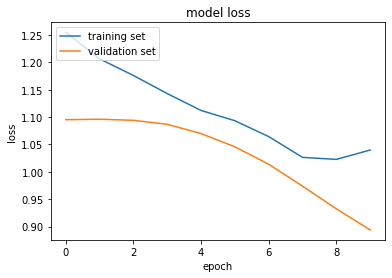

In [20]:
import matplotlib.pyplot as plt

history_fine = model.history
loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.plot(history_fine.history['loss'])
plt.plot(history_fine.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training set','validation set'], loc='upper left')
plt.show()

In [25]:
y_prob = model.predict(test_generator)
y_pred = np.argmax(y_prob,axis=1)

In [24]:
y_prob

array([[0.43368167, 0.2531004 , 0.3132179 ],
       [0.29389828, 0.42728916, 0.27881253],
       [0.34789807, 0.31084755, 0.3412544 ],
       ...,
       [0.56786627, 0.18841502, 0.24371867],
       [0.41249105, 0.23433988, 0.35316902],
       [0.3382568 , 0.31159598, 0.3501472 ]], dtype=float32)

In [26]:
y_test = test_generator.classes

In [27]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.36      0.55      0.43       180
           1       0.28      0.26      0.27       170
           2       0.29      0.16      0.20       184

    accuracy                           0.32       534
   macro avg       0.31      0.32      0.30       534
weighted avg       0.31      0.32      0.30       534



#Usando PyTesseract

In [1]:
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pytesseract
import shutil
import os
import random
try:
    from PIL import Image
except ImportError:
    import Image

In [3]:
from google.colab import files

uploaded = files.upload()

Saving 0005.tif to 0005.tif


In [4]:
extractedInformation = pytesseract.image_to_string(Image.open('0005.tif'))

In [5]:
extractedInformation

"a) THE NEW LOOK\nINGOLD\n# AND SILVER!\n\nSURGEON GENERAL'S WARNIN' jokin:\nCauses Lung Cancer, Hear ase,\nEmphy And May Complicate empane)\n\n \n\x0c"